# Import necessary libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set Matplotlib and Seaborn styles for better visualization
plt.style.use('ggplot')
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10

# Load the data

In [2]:
df = pd.read_csv('vendor_aging.csv')

# Display basic information about the dataset
print("Dataset Overview:")
print(f"Number of rows: {df.shape[0]}")
print(f"Number of columns: {df.shape[1]}")
print("\nColumn list:")
print(df.columns.tolist())

Dataset Overview:
Number of rows: 3600
Number of columns: 22

Column list:
['Snapshot_Date', 'SalesPerson_Name', 'SalesPersonID', 'AccountManager_ID', 'AccountManager_Name', 'country_id', 'country_name', 'Company', 'Vendor ID', 'Vendor', 'Balance Outstanding', 'Future_Aging', 'Aging_0_30', 'Aging_31_60', 'Aging_61_90', 'Aging_91_120', 'Aging_121_180', 'Aging_181_360', 'Above_361_Aging', '%GT', 'LP Date', 'Vendor LP Amount']


# Prepare time series data

In [3]:
def prepare_time_series_data(df, snapshot_date_col='Snapshot_Date', vendor_id_col='Vendor ID'):
    """
    Prepare vendor aging data for time series analysis by handling snapshot dates.

    Args:
        df (pandas.DataFrame): Raw vendor aging data with multiple snapshots
        snapshot_date_col (str): Column containing snapshot date
        vendor_id_col (str): Column containing vendor identifier

    Returns:
        pandas.DataFrame: Prepared DataFrame with proper date formats
    """
    # Create a copy to avoid modifying the original
    result_df = df.copy()

    # Convert snapshot date to datetime if it's not already
    if not pd.api.types.is_datetime64_any_dtype(result_df[snapshot_date_col]):
        result_df[snapshot_date_col] = pd.to_datetime(result_df[snapshot_date_col], errors='coerce')

    # Convert last payment date to datetime if it exists
    if 'LP Date' in result_df.columns and not pd.api.types.is_datetime64_any_dtype(result_df['LP Date']):
        result_df['LP Date'] = pd.to_datetime(result_df['LP Date'], errors='coerce')

    # Sort data by vendor and date
    result_df = result_df.sort_values([vendor_id_col, snapshot_date_col])

    # Add a year-month column for easier grouping
    result_df['Year_Month'] = result_df[snapshot_date_col].dt.to_period('M')

    return result_df

In [4]:
# Apply the function
prepared_df = prepare_time_series_data(df)

# Display the data types after preparation
print("\nData types after preparation:")
print(prepared_df.dtypes.head(10))


Data types after preparation:
Snapshot_Date          datetime64[ns]
SalesPerson_Name               object
SalesPersonID                   int64
AccountManager_ID               int64
AccountManager_Name            object
country_id                      int64
country_name                   object
Company                        object
Vendor ID                       int64
Vendor                         object
dtype: object


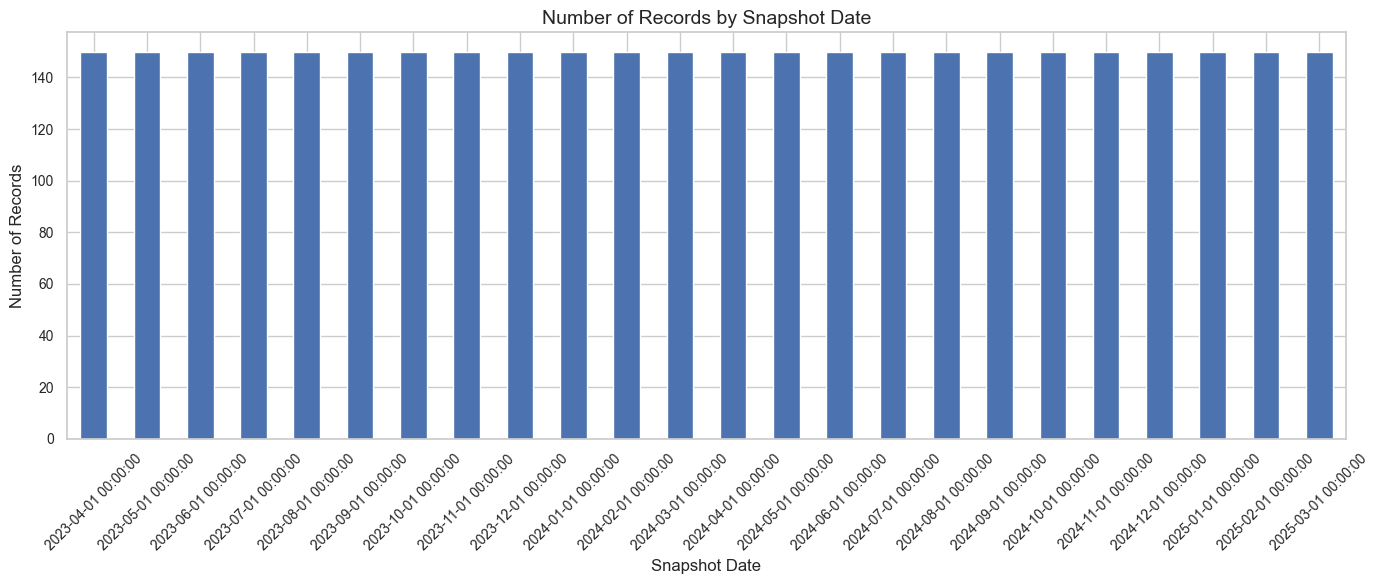

In [5]:
# Visualize the number of records by snapshot date
plt.figure(figsize=(14, 6))
snapshot_counts = prepared_df.groupby('Snapshot_Date')['Vendor ID'].count()
snapshot_counts.plot(kind='bar')
plt.title('Number of Records by Snapshot Date')
plt.xlabel('Snapshot Date')
plt.ylabel('Number of Records')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [6]:
print("\nUnique snapshot dates:")
print(prepared_df['Snapshot_Date'].dt.strftime('%Y-%m-%d').unique())


Unique snapshot dates:
['2023-04-01' '2023-05-01' '2023-06-01' '2023-07-01' '2023-08-01'
 '2023-09-01' '2023-10-01' '2023-11-01' '2023-12-01' '2024-01-01'
 '2024-02-01' '2024-03-01' '2024-04-01' '2024-05-01' '2024-06-01'
 '2024-07-01' '2024-08-01' '2024-09-01' '2024-10-01' '2024-11-01'
 '2024-12-01' '2025-01-01' '2025-02-01' '2025-03-01']


# Create vendor snapshot pivot

In [7]:
def create_vendor_snapshot_pivot(df, value_col='Balance Outstanding', snapshot_date_col='Snapshot_Date',
                               vendor_id_col='Vendor ID', vendor_name_col='Vendor',
                               fill_method='ffill'):
    """
    Create a pivot table with vendors as rows and snapshot dates as columns.

    Args:
        df (pandas.DataFrame): Prepared vendor aging data
        value_col (str): Column to use as the values in the pivot
        snapshot_date_col (str): Column containing snapshot date
        vendor_id_col (str): Column containing vendor identifier
        vendor_name_col (str): Column containing vendor name
        fill_method (str): Method to fill missing values ('ffill', 'bfill', None)

    Returns:
        pandas.DataFrame: Pivot table with vendors as rows and dates as columns
    """
    # Create a copy of the data with just the needed columns
    pivot_data = df[[vendor_id_col, vendor_name_col, snapshot_date_col, value_col]].copy()

    # Create the pivot table
    pivot = pivot_data.pivot_table(
        index=[vendor_id_col, vendor_name_col],
        columns=snapshot_date_col,
        values=value_col,
        aggfunc='first'  # Use first value in case of duplicates
    )

    # Fill missing values if specified
    if fill_method:
        pivot = pivot.fillna(method=fill_method)

    return pivot

In [8]:
# Create pivot table for Balance Outstanding
balance_pivot = create_vendor_snapshot_pivot(prepared_df)

# Display a sample of the pivot table
print("\nSample of pivot table (Balance Outstanding):")
print(balance_pivot.head())



Sample of pivot table (Balance Outstanding):
Snapshot_Date             2023-04-01  2023-05-01  2023-06-01  2023-07-01  \
Vendor ID Vendor                                                           
1         Lisa Hensley     279231.88   417903.91   571509.56   555200.77   
2         Victoria Wyatt   133168.18   201808.44   267376.88   281393.51   
3         Holly Wood       961676.14  1262119.46  1581479.59  1576820.02   
4         Maria Lynch      214335.94   296802.22   408722.53   425386.45   
5         James Mayo        21855.28    33574.43    42192.35    39889.23   

Snapshot_Date             2023-08-01  2023-09-01  2023-10-01  2023-11-01  \
Vendor ID Vendor                                                           
1         Lisa Hensley     690995.08   864460.79   522923.11   656779.20   
2         Victoria Wyatt   358449.48   412627.25   335144.67   402985.15   
3         Holly Wood      1914224.33  2261395.02  2041510.07  2419490.00   
4         Maria Lynch      510708.15   62

/var/folders/jm/1g1gqypd2s3c08lbh6tr1lz00000gn/T/ipykernel_76212/1030571147.py:31: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  pivot = pivot.fillna(method=fill_method)


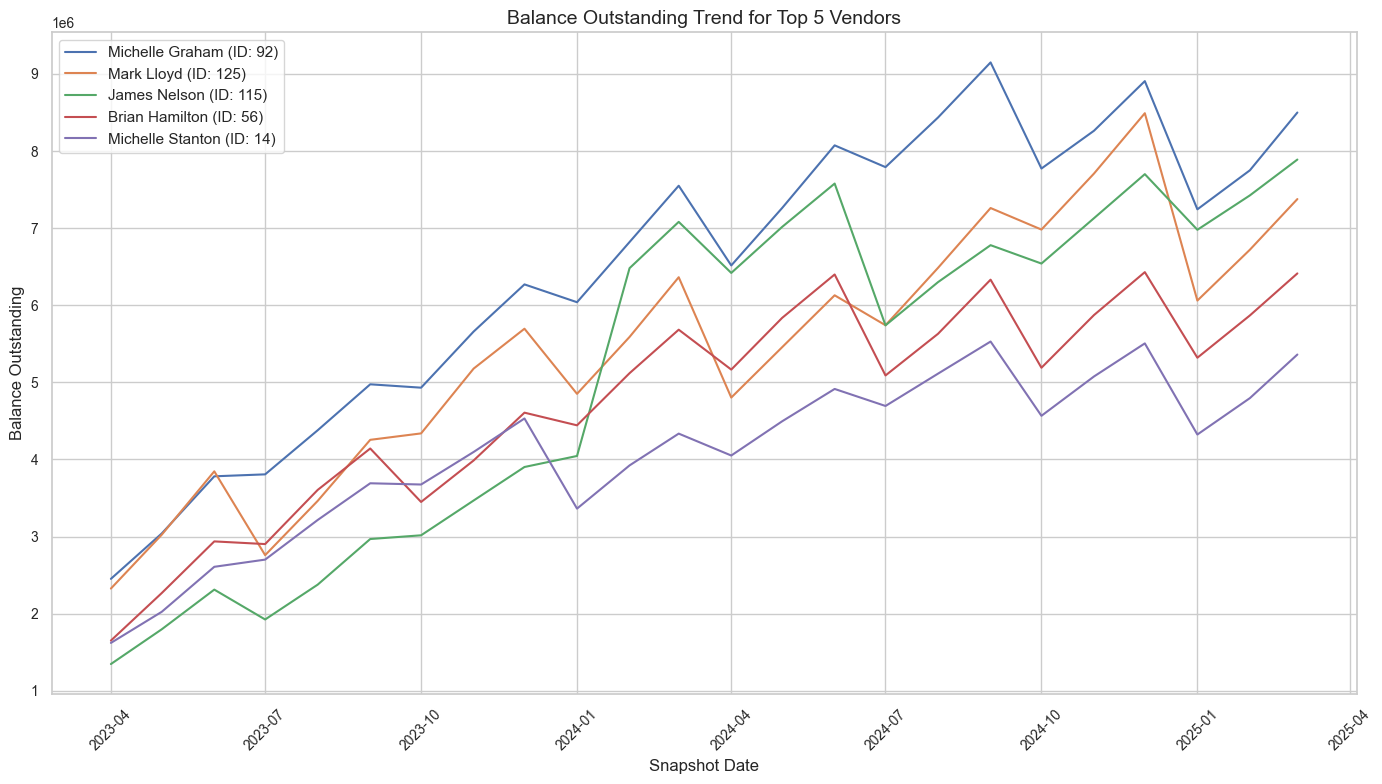

In [9]:
# Visualize the balance trend for a few top vendors
top_vendors = balance_pivot.mean(axis=1).sort_values(ascending=False).head(5).index
plt.figure(figsize=(14, 8))
for vendor_id, vendor_name in top_vendors:
    plt.plot(balance_pivot.loc[(vendor_id, vendor_name)], label=f"{vendor_name} (ID: {vendor_id})")

plt.title('Balance Outstanding Trend for Top 5 Vendors')
plt.xlabel('Snapshot Date')
plt.ylabel('Balance Outstanding')
plt.legend(loc='best')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Calculate aging metrics over time

In [10]:
def calculate_aging_metrics_over_time(df, snapshot_date_col='Snapshot_Date',
                                    aging_cols=None, vendor_id_col='Vendor ID'):
    """
    Calculate aging metrics for each vendor across snapshots.

    Args:
        df (pandas.DataFrame): Prepared vendor aging data
        snapshot_date_col (str): Column containing snapshot date
        aging_cols (list): List of aging bucket columns
        vendor_id_col (str): Column containing vendor identifier

    Returns:
        pandas.DataFrame: DataFrame with calculated metrics by vendor and snapshot
    """
    # Define default aging columns if not specified
    if aging_cols is None:
        aging_cols = [
            'Future_Aging', 'Aging_0_30', 'Aging_31_60', 'Aging_61_90',
            'Aging_91_120', 'Aging_121_180', 'Aging_181_360', 'Above_361_Aging'
        ]

    # Create a copy to avoid modifying the original
    result_df = df.copy()

    # Calculate total aging for each snapshot
    result_df['Total_Aging'] = result_df[aging_cols].sum(axis=1)

    # Calculate aging beyond 90 days
    aging_beyond_90_cols = [col for col in aging_cols if '91' in col or '120' in col or
                           '180' in col or '360' in col or 'Above_361' in col]

    result_df['Aging_Beyond_90'] = result_df[aging_beyond_90_cols].sum(axis=1)

    # Calculate aging percentages
    for col in aging_cols:
        result_df[f'{col}_Pct'] = (result_df[col] / result_df['Total_Aging'].replace(0, np.nan)) * 100
        result_df[f'{col}_Pct'] = result_df[f'{col}_Pct'].fillna(0)

    # Calculate percentage of aging beyond 90 days
    result_df['Pct_Aging_Beyond_90'] = (result_df['Aging_Beyond_90'] /
                                      result_df['Total_Aging'].replace(0, np.nan)) * 100
    result_df['Pct_Aging_Beyond_90'] = result_df['Pct_Aging_Beyond_90'].fillna(0)

    return result_df

In [11]:
metrics_df = calculate_aging_metrics_over_time(prepared_df)

# Display the new columns
print("\nColumns after calculating aging metrics:")
print([col for col in metrics_df.columns if 'Aging' in col and 'Pct' in col])


Columns after calculating aging metrics:
['Future_Aging_Pct', 'Aging_0_30_Pct', 'Aging_31_60_Pct', 'Aging_61_90_Pct', 'Aging_91_120_Pct', 'Aging_121_180_Pct', 'Aging_181_360_Pct', 'Above_361_Aging_Pct', 'Pct_Aging_Beyond_90']


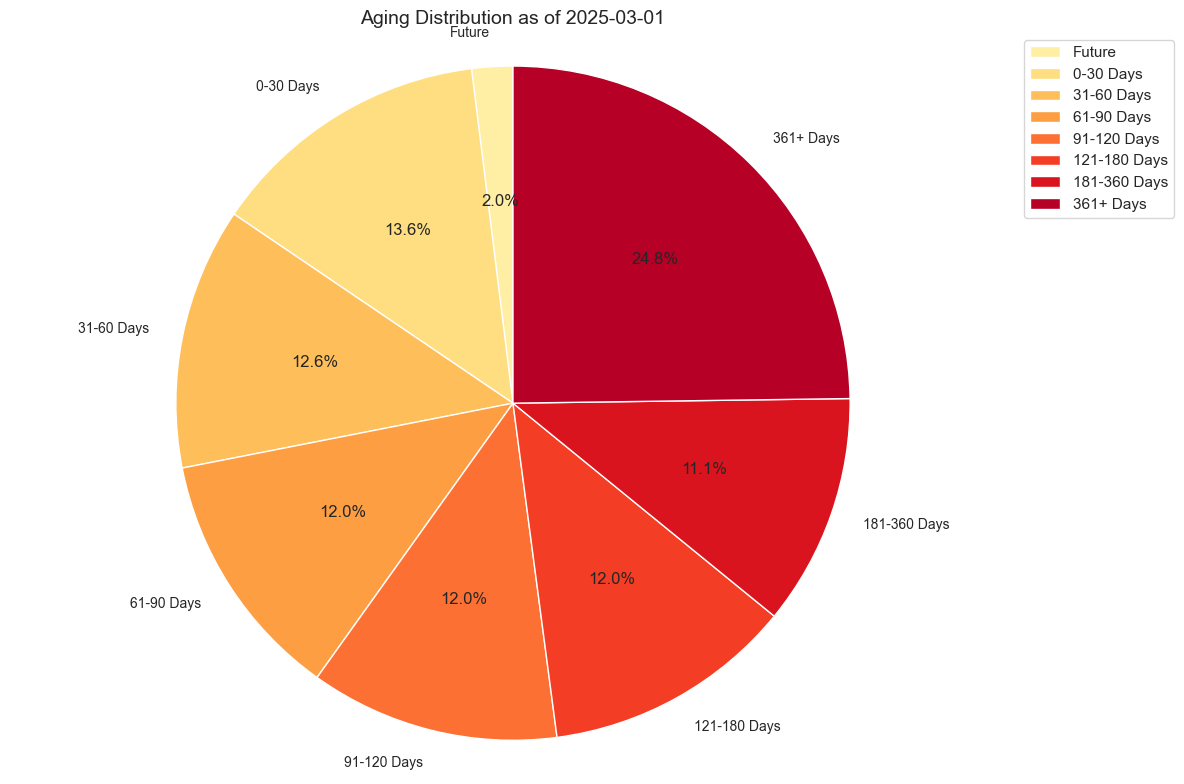

In [12]:
# Visualize the aging distribution across the entire dataset
latest_date = metrics_df['Snapshot_Date'].max()
latest_data = metrics_df[metrics_df['Snapshot_Date'] == latest_date]

# Create a pie chart of aging buckets for the latest snapshot
aging_cols = [
    'Future_Aging', 'Aging_0_30', 'Aging_31_60', 'Aging_61_90',
    'Aging_91_120', 'Aging_121_180', 'Aging_181_360', 'Above_361_Aging'
]

aging_labels = [
    'Future', '0-30 Days', '31-60 Days', '61-90 Days',
    '91-120 Days', '121-180 Days', '181-360 Days', '361+ Days'
]

aging_values = [latest_data[col].sum() for col in aging_cols]

plt.figure(figsize=(12, 8))
plt.pie(aging_values, labels=aging_labels, autopct='%1.1f%%', startangle=90,
       colors=sns.color_palette("YlOrRd", len(aging_cols)))
plt.axis('equal')
plt.title(f'Aging Distribution as of {latest_date.strftime("%Y-%m-%d")}')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

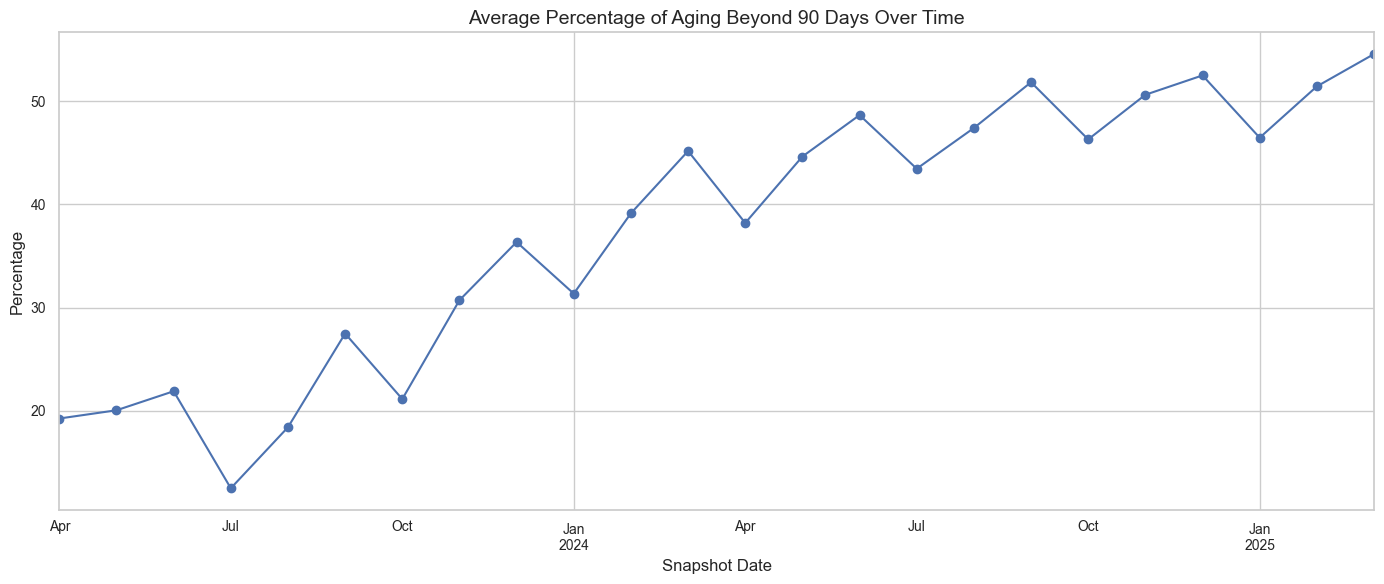

In [13]:
# Visualize the percentage of aging beyond 90 days over time
plt.figure(figsize=(14, 6))
avg_aging_beyond_90 = metrics_df.groupby('Snapshot_Date')['Pct_Aging_Beyond_90'].mean()
avg_aging_beyond_90.plot(marker='o')
plt.title('Average Percentage of Aging Beyond 90 Days Over Time')
plt.xlabel('Snapshot Date')
plt.ylabel('Percentage')
plt.grid(True)
plt.tight_layout()
plt.show()

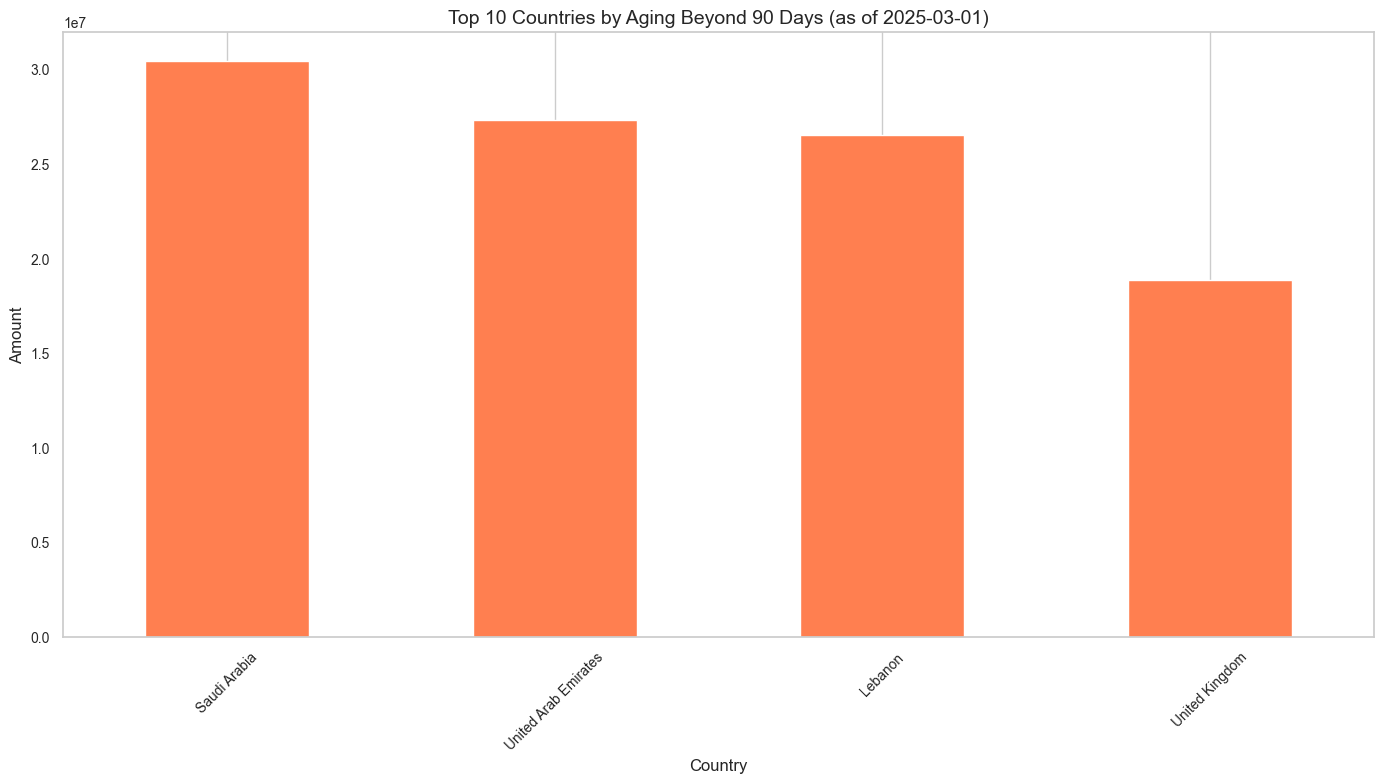

In [14]:
# Aging distribution by country
plt.figure(figsize=(14, 8))
country_aging = metrics_df[metrics_df['Snapshot_Date'] == latest_date].groupby('country_name')['Aging_Beyond_90'].sum().sort_values(ascending=False).head(10)
country_aging.plot(kind='bar', color='coral')
plt.title(f'Top 10 Countries by Aging Beyond 90 Days (as of {latest_date.strftime("%Y-%m-%d")})')
plt.xlabel('Country')
plt.ylabel('Amount')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [15]:
print("\n" + "="*80)
print("SUMMARY OF DATA PREPARATION FUNCTIONS")
print("="*80)
print("\n1. prepare_time_series_data:")
print("   - Converts date columns to proper datetime format")
print("   - Sorts data by vendor and date")
print("   - Adds year-month column for easier time-based grouping")
print("   - Critical for any time series analysis")

print("\n2. create_vendor_snapshot_pivot:")
print("   - Creates a vendor-date matrix for analyzing trends over time")
print("   - Makes it easy to visualize how a metric changes for each vendor")
print("   - Helps identify vendors with unusual patterns")

print("\n3. calculate_aging_metrics_over_time:")
print("   - Calculates total aging and aging beyond 90 days")
print("   - Computes percentage distributions for aging buckets")
print("   - Creates normalized metrics for fair vendor comparison")
print("   - Foundation for all subsequent aging analyses")

print("\nThese three functions form the foundation for all subsequent analyses.")
print("They transform raw accounting data into a time-series ready format with")
print("derived metrics that enable trend analysis, anomaly detection, and")
print("prescriptive recommendations.")


SUMMARY OF DATA PREPARATION FUNCTIONS

1. prepare_time_series_data:
   - Converts date columns to proper datetime format
   - Sorts data by vendor and date
   - Adds year-month column for easier time-based grouping
   - Critical for any time series analysis

2. create_vendor_snapshot_pivot:
   - Creates a vendor-date matrix for analyzing trends over time
   - Makes it easy to visualize how a metric changes for each vendor
   - Helps identify vendors with unusual patterns

3. calculate_aging_metrics_over_time:
   - Calculates total aging and aging beyond 90 days
   - Computes percentage distributions for aging buckets
   - Creates normalized metrics for fair vendor comparison
   - Foundation for all subsequent aging analyses

These three functions form the foundation for all subsequent analyses.
They transform raw accounting data into a time-series ready format with
derived metrics that enable trend analysis, anomaly detection, and
prescriptive recommendations.
